#用梯度提升回归从误差中学习

梯度提升回归（Gradient boosting regression，GBR）是一种从它的错误中进行学习的技术。它本质上就是集思广益，集成一堆较差的学习算法进行学习。有两点需要注意：
- 每个学习算法准备率都不高，但是它们集成起来可以获得很好的准确率。
- 这些学习算法依次应用，也就是说每个学习算法都是在前一个学习算法的错误中学习

<!-- TEASER_END -->

##Getting ready

我们还是用基本的回归数据来演示GBR：

In [14]:
import numpy as np
from sklearn.datasets import make_regression
X, y = make_regression(1000, 2, noise=10)

##How to do it...

GBR算是一种集成模型因为它是一个集成学习算法。这种称谓的含义是指GBR用许多较差的学习算法组成了一个更强大的学习算法：

In [15]:
from sklearn.ensemble import GradientBoostingRegressor as GBR
gbr = GBR()
gbr.fit(X, y)
gbr_preds = gbr.predict(X)

很明显，这里应该不止一个模型，但是这种模式现在很简明。现在，让我们用基本回归算法来拟合数据当作参照：

In [16]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(X, y)
lr_preds = lr.predict(X)

有了参照之后，让我们看看GBR算法与线性回归算法效果的对比情况。图像生成可以参照第一章正态随机过程的相关主题，首先需要下面的计算：

In [17]:
gbr_residuals = y - gbr_preds
lr_residuals = y - lr_preds

In [ ]:
%matplotlib inline
from matplotlib import pyplot as plt

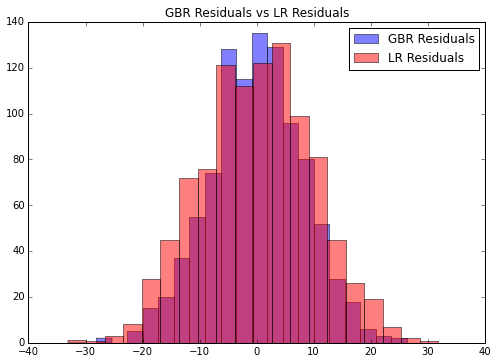

In [18]:
f, ax = plt.subplots(figsize=(7, 5))
f.tight_layout()
ax.hist(gbr_residuals,bins=20,label='GBR Residuals', color='b', alpha=.5);
ax.hist(lr_residuals,bins=20,label='LR Residuals', color='r', alpha=.5);
ax.set_title("GBR Residuals vs LR Residuals")
ax.legend(loc='best');

看起来好像GBR拟合的更好，但是并不明显。让我们用95%置信区间（Confidence interval,CI）对比一下：

In [19]:
np.percentile(gbr_residuals, [2.5, 97.5])

array([-16.73937398,  15.96258406])

In [20]:
np.percentile(lr_residuals, [2.5, 97.5])

array([-19.03378242,  19.45950191])

GBR的置信区间更小，数据更集中，因此其拟合效果更好；我们还可以对GBR算法进行一些调整来改善效果。我用下面的例子演示一下，然后在下一节介绍优化方法：

In [23]:
n_estimators = np.arange(100, 1100, 350)
gbrs = [GBR(n_estimators=n_estimator) for n_estimator in n_estimators]
residuals = {}
for i, gbr in enumerate(gbrs):
    gbr.fit(X, y)
    residuals[gbr.n_estimators] = y - gbr.predict(X)

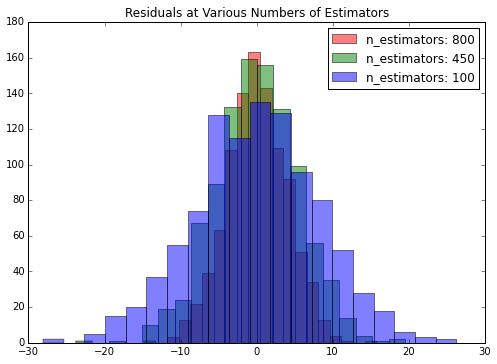

In [30]:
f, ax = plt.subplots(figsize=(7, 5))
f.tight_layout()
colors = {800:'r', 450:'g', 100:'b'}
for k, v in residuals.items():
    ax.hist(v,bins=20,label='n_estimators: %d' % k, color=colors[k], alpha=.5);
ax.set_title("Residuals at Various Numbers of Estimators")
ax.legend(loc='best');

图像看着有点混乱，但是依然可以看出随着估计器数据的增加，误差在减少。不过，这并不是一成不变的。首先，我们没有交叉检验过，其次，随着估计器数量的增加，训练时间也会变长。现在我们用数据比较小没什么关系，但是如果数据再放大一两倍问题就出来了。

##How it works...

上面例子中GBR的第一个参数是`n_estimators`，指GBR使用的学习算法的数量。通常，如果你的设备性能更好，可以把`n_estimators`设置的更大，效果也会更好。还有另外几个参数要说明一下。

你应该在优化其他参数之前先调整`max_depth`参数。因为每个学习算法都是一颗决策树，`max_depth`决定了树生成的节点数。选择合适的节点数量可以更好的拟合数据，而更多的节点数可能造成拟合过度。

`loss`参数决定损失函数，也直接影响误差。`ls`是默认值，表示最小二乘法（least squares）。还有最小绝对值差值，Huber损失和分位数损失（quantiles）等等。